In [1]:
# import libraries
import sklearn
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    LabelBinarizer,)

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,classification_report, roc_auc_score,roc_curve)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


import seaborn as sns
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import warnings

In [2]:
#import ONLY the columns that will be used *NOT completely clean*
#counter columns were added and names of medications were dropped
importedcolms=['age','num_lab_procedures','num_procedures', 'num_medications','diag_1','diag_2','diag_3','change','change_counter','steady_counter','diabetesMed','readmitted']

In [3]:
df= pd.read_csv('diabetic_dataPreprocessing.csv', usecols=importedcolms)

In [4]:
df.head()

,age,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,diabetesMed,change,change_counter,steady_counter,readmitted
0,[0-10),41,0,1,250.83,?,?,No,No,0,0,NO
1,[10-20),59,0,18,276,250.01,255,Yes,Yes,1,0,>30
2,[20-30),11,5,13,648,250,V27,Yes,No,0,1,NO
3,[30-40),44,1,16,8,250.43,403,Yes,Yes,1,0,NO
4,[40-50),51,0,8,197,157,250,Yes,Yes,0,2,NO


In [5]:
# Drop the rows [0-10) & [10-20) from age column
row_drop = df[df['age'].isin(['[0-10)', '[10-20)'])].index
df = df.drop(index=row_drop)

In [6]:
# use a function to drop any diagnoses NOT related to diabetes within diag_1-3
def apply(value):
    try:
        # Convert to float for range comparisons
        value_float = float(value)
        if 249.00 <= value_float <= 250.99:
            return True
        if 362.00 <= value_float <= 362.02 or 362.04 <= value_float <= 362.07:
            return True
    except ValueError:
        # For string comparisons
        if value in ['357.2', '366.41', 'v885', 'v5991', 'v6546', 'v5867']:
            return True
    return False

# Process each column separately
for column in ['diag_1', 'diag_2', 'diag_3']:
    # Replace values not matching the criteria with NaN
    df[column] = df[column].apply(lambda x: x if apply(x) else np.nan)

# Drop rows with NaN in diag_1-3
df = df.dropna(how='all', subset=['diag_1', 'diag_2', 'diag_3'])

print(df)

            age  num_lab_procedures  num_procedures  num_medications  diag_1  \
2       [20-30)                  11               5               13     NaN   
3       [30-40)                  44               1               16     NaN   
4       [40-50)                  51               0                8     NaN   
5       [50-60)                  31               6               16     NaN   
7       [70-80)                  73               0               12     NaN   
...         ...                 ...             ...              ...     ...   
101750  [80-90)                  31               2               24     NaN   
101753  [40-50)                  51               2               13   250.8   
101754  [70-80)                  50               2               33     NaN   
101759  [80-90)                   1               0               15     NaN   
101761  [70-80)                  51               0               16  250.13   

        diag_2  diag_3 diabetesMed chan

ChatGPT was used to help with this section. I didn't know how to put in the conditions and how to do it simultaneously with all 3 columns. I was trying to use drop.na() but I can't drop the row or column because then I would be left with no data after running all three diags...

In [7]:
# join columns diag_1-3 to diag

#fill any na value in that row with the value from the next columns 
df['diag'] = df['diag_1'].fillna(df['diag_2']).fillna(df['diag_3'])

# Drop diag_1-3 
df = df.drop(columns=['diag_1', 'diag_2', 'diag_3'])

#diag is added as last column so I made a temp variable to pop it then insert it back to where I wanted it 
diag_column = df.pop("diag")  
df.insert(df.columns.get_loc("num_medications"), "diag", diag_column)  # Insert before 'num_medications'

print(df)


            age  num_lab_procedures  num_procedures    diag  num_medications  \
2       [20-30)                  11               5     250               13   
3       [30-40)                  44               1  250.43               16   
4       [40-50)                  51               0     250                8   
5       [50-60)                  31               6     250               16   
7       [70-80)                  73               0     250               12   
...         ...                 ...             ...     ...              ...   
101750  [80-90)                  31               2     250               24   
101753  [40-50)                  51               2   250.8               13   
101754  [70-80)                  50               2  250.02               33   
101759  [80-90)                   1               0     250               15   
101761  [70-80)                  51               0  250.13               16   

       diabetesMed change  change_count

ChatGPT was used for this section because I didn't know how to join columns. For this data, I realized that I could check the column for NaN, and if it's NaN then that could be dropped to reduce dimensionality. The way I was originally doing it dropped the row if NaN was in diag_1 before checking diag_2 and diag_3. This is why I made it go through all 3 columns before dropping anything. Now I have no NaN values. 

In [8]:
# function to categorize diagnoses
def categorize_diag(value):
    try:
        value_float = float(value) 
        if value_float in [249.6, 250.6, 250.61, 357.20]:
            return 1
        elif value_float in [249.50, 250.50, 250.51, 362.01, 362.02, 362.03, 362.04, 362.05, 362.06, 362.07]:
            return 2
        elif value_float in [249.70, 250.70, 250.71]:
            return 3
        elif value_float in [249.40, 250.40, 250.41]:
            return 4
        elif value_float in [249.80, 249.90, 250.80, 250.81, 250.90, 250.91]:
            return 5
        elif value_float == 366.41:
            return 6
        elif value_float == 249.00:
            return 7
        elif value_float == 250.01:
            return 8
        elif value_float == 250.00:
            return 9
        else:
            return None  
    except ValueError:
        return None 

# Replace values in the 'diag' column directly
df['diag'] = df['diag'].apply(categorize_diag)

# uncategorized diagnoses
uncategorized = df[df['diag'].isna()]

# Drop rows with uncategorized diagnoses
df = df.dropna(subset=['diag'])
print(df)



            age  num_lab_procedures  num_procedures  diag  num_medications  \
2       [20-30)                  11               5   9.0               13   
4       [40-50)                  51               0   9.0                8   
5       [50-60)                  31               6   9.0               16   
7       [70-80)                  73               0   9.0               12   
10      [40-50)                  47               2   3.0               17   
...         ...                 ...             ...   ...              ...   
101748  [40-50)                  69               0   9.0               16   
101749  [70-80)                  27               1   9.0               29   
101750  [80-90)                  31               2   9.0               24   
101753  [40-50)                  51               2   5.0               13   
101759  [80-90)                   1               0   9.0               15   

       diabetesMed change  change_counter  steady_counter readm

To minimize the amount of diagonses I grouped them into a category from 1-9

In [9]:
# since they are all on diabetic medication I decided to drop that column
df.drop(axis=1, labels=['diabetesMed'])

,age,num_lab_procedures,num_procedures,diag,num_medications,change,change_counter,steady_counter,readmitted
2,[20-30),11,5,9.0,13,No,0,1,NO
4,[40-50),51,0,9.0,8,Yes,0,2,NO
5,[50-60),31,6,9.0,16,No,0,1,>30
7,[70-80),73,0,9.0,12,No,0,1,>30
10,[40-50),47,2,3.0,17,No,0,1,>30
...,...,...,...,...,...,...,...,...,...
101748,[40-50),69,0,9.0,16,Yes,2,1,>30
101749,[70-80),27,1,9.0,29,Yes,0,3,NO
101750,[80-90),31,2,9.0,24,Yes,1,0,<30
101753,[40-50),51,2,5.0,13,Yes,1,1,NO


In [10]:
# Convert 'readmitted' to 'Yes' for '<30' or '>30' and 'No' for 'No'
df['readmitted'] = df['readmitted'].apply(lambda x: 'Yes' if x in ['<30', '>30'] else 'No')

# Encode 'readmitted' for models (0 for 'No', 1 for 'Yes')
encoder = LabelEncoder()
df['readmitted'] = encoder.fit_transform(df['readmitted'])

In [11]:
df.isnull().sum()

age                   0
num_lab_procedures    0
num_procedures        0
diag                  0
num_medications       0
diabetesMed           0
change                0
change_counter        0
steady_counter        0
readmitted            0
dtype: int64

In [12]:
print(df[['num_lab_procedures','num_procedures', 'num_medications', 'change_counter', 'steady_counter']].describe())


       num_lab_procedures  num_procedures  num_medications  change_counter  \
count        28295.000000    28295.000000     28295.000000    28295.000000   
mean            39.265453        1.279025        14.672663        0.258420   
std             18.779318        1.622020         7.601169        0.469032   
min              1.000000        0.000000         1.000000        0.000000   
25%             28.000000        0.000000         9.000000        0.000000   
50%             41.000000        1.000000        13.000000        0.000000   
75%             52.000000        2.000000        19.000000        0.000000   
max            114.000000        6.000000        67.000000        4.000000   

       steady_counter  
count    28295.000000  
mean         0.939247  
std          0.915543  
min          0.000000  
25%          0.000000  
50%          1.000000  
75%          1.000000  
max          5.000000  


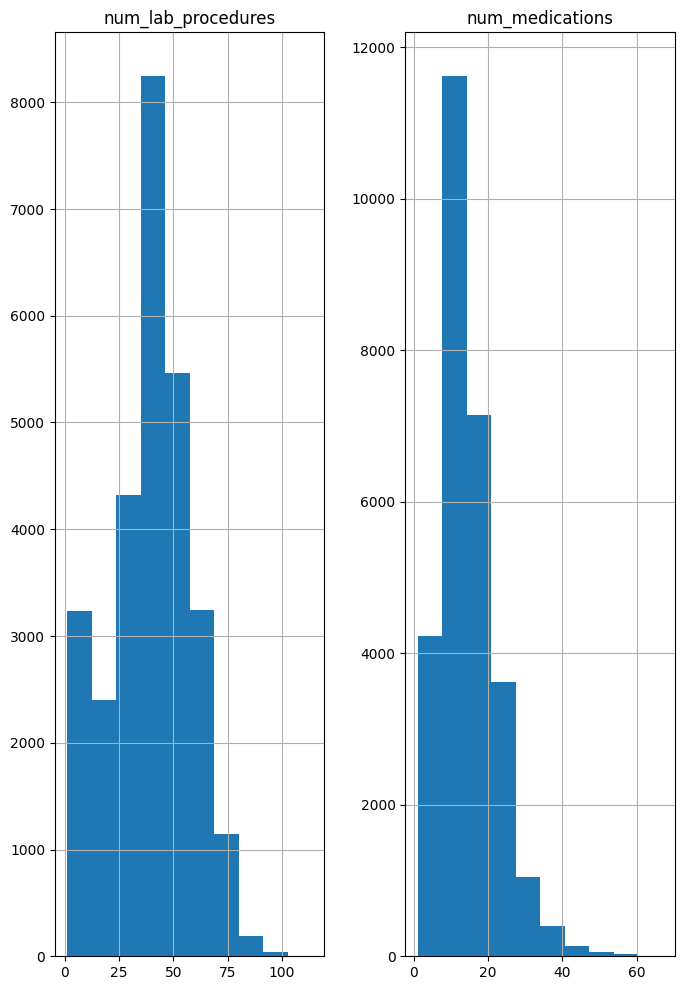

In [13]:
#histogram for num_lab_proceduers & num_medications

df[['num_lab_procedures', 'num_medications']].hist(figsize=(8, 12))
plt.show()


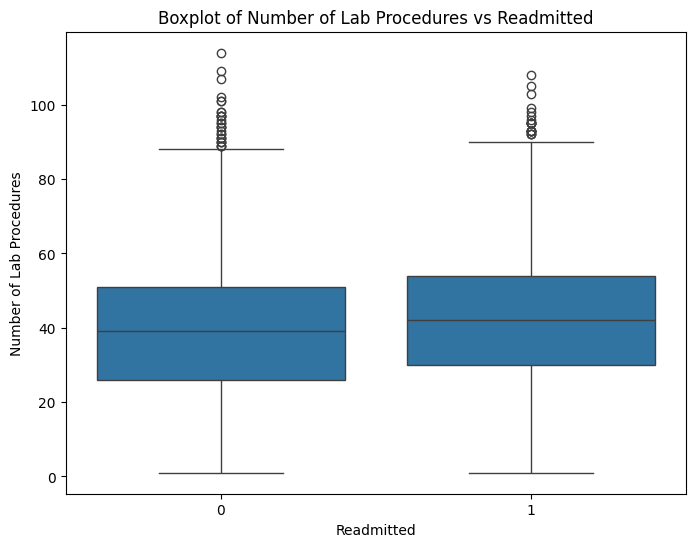

In [14]:
# boxplot readmitted & num_lab_procedures
plt.figure(figsize=(8, 6))
sns.boxplot(x="readmitted", y="num_lab_procedures", data=df)

# Add labels and title
plt.title("Boxplot of Number of Lab Procedures vs Readmitted")
plt.xlabel("Readmitted")
plt.ylabel("Number of Lab Procedures")
plt.show()

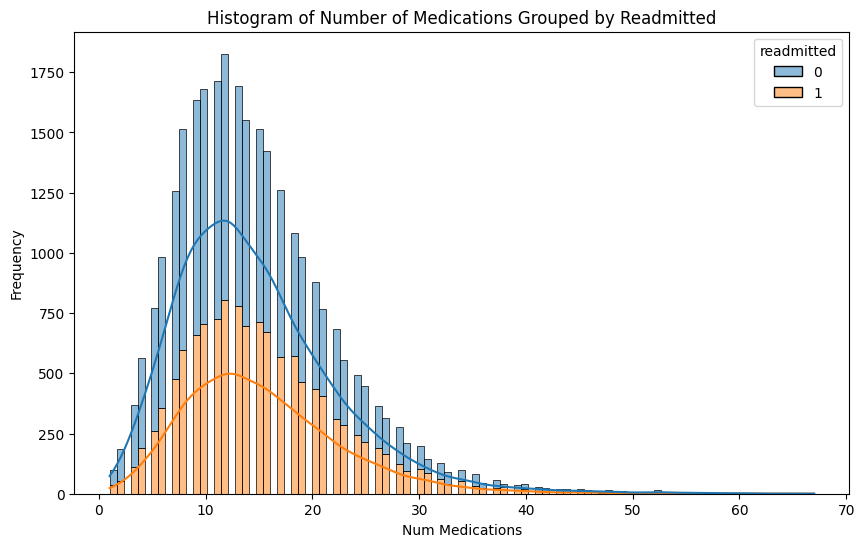

In [15]:
# histogram grouped by 'readmitted'
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='num_medications', hue='readmitted', kde=True, multiple='stack')

plt.title('Histogram of Number of Medications Grouped by Readmitted')
plt.xlabel('Num Medications')
plt.ylabel('Frequency')
plt.show()



normalize for log reg

In [16]:
#normalize and print distribution
print('\n',df['age'].value_counts(normalize=True))

print('\n', df['change'].value_counts(normalize=True))

print('\n',df['readmitted'].value_counts(normalize=True))



 age
[60-70)     0.229687
[70-80)     0.228344
[50-60)     0.203004
[40-50)     0.127796
[80-90)     0.120622
[30-40)     0.052094
[20-30)     0.020074
[90-100)    0.018378
Name: proportion, dtype: float64

 change
No     0.546528
Yes    0.453472
Name: proportion, dtype: float64

 readmitted
0    0.558968
1    0.441032
Name: proportion, dtype: float64


In [17]:
# Convert 'change' column to binary
df['change'] = df['change'].map({'Yes': 1, 'No': 0})

# Convert 'diag' to categorical numeric codes
df['diag'] = df['diag'].astype('category').cat.codes

# Define a function to replace age ranges with midpoints
def age_to_midpoint(age_range):
    try:
        # Extract the numbers and calculate the midpoint
        lower, upper = map(int, age_range.strip('[]()').split('-'))
        return (lower + upper) / 2
    except:
        return np.nan

# Apply the function to the 'age' column
df['age'] = df['age'].apply(age_to_midpoint)

print(df.head())

     age  num_lab_procedures  num_procedures  diag  num_medications  \
2   25.0                  11               5     6               13   
4   45.0                  51               0     6                8   
5   55.0                  31               6     6               16   
7   75.0                  73               0     6               12   
10  45.0                  47               2     2               17   

   diabetesMed  change  change_counter  steady_counter  readmitted  
2          Yes       0               0               1           0  
4          Yes       1               0               2           0  
5          Yes       0               0               1           1  
7          Yes       0               0               1           1  
10         Yes       0               0               1           1  


In [18]:
# Selecting the features (X) and target (y)
X = df[['age', 'num_lab_procedures', 'num_procedures', 'diag', 
        'num_medications', 'change', 'change_counter', 'steady_counter']]
y = df['readmitted']

# One-hot encoding 'age' and 'diag'
X = pd.get_dummies(X, columns=['age', 'diag'], drop_first=True)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
# Standardize features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model
lr = LogisticRegression(random_state=42, max_iter=1000, penalty=None)
lr.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68      3163
           1       0.56      0.37      0.45      2496

    accuracy                           0.60      5659
   macro avg       0.59      0.57      0.56      5659
weighted avg       0.59      0.60      0.58      5659



In [20]:
# Logistic regression tuning
# Subset the data for faster tuning
X_subset, _, y_subset, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Define the search space for Logistic Regression
search_space = {
    'C': Real(0.01, 10, prior='log-uniform'),  # Regularization strength
    'penalty': Categorical(['l2', 'l1']),     # Penalty type
    'solver': Categorical(['liblinear', 'saga'])  # Solvers supporting 'l1' penalty
}

# Set up BayesSearchCV for Logistic Regression
bayes_search = BayesSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=500),  # Base Logistic Regression model
    search_spaces=search_space,
    n_iter=20,                 # Number of iterations
    cv=3,                      # Cross-validation folds
    n_jobs=-1,                 # Use all CPU cores
    random_state=42,
    verbose=2
)

# Fit the model
bayes_search.fit(X_subset, y_subset)

# Print the best parameters and classification report
print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)

# Evaluate the best model on the test set
y_pred = bayes_search.best_estimator_.predict(X_test)
print("Logisitc Regression Fine-Tuned Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

To fine-tune the models I tried to use GridSearchCV but it was taking too long. I then tried RandomSearchCV and reduced the hyperparameters but it still took too long. I googled how to reduce the run time and found bayesian Optimization in scikit-optimize. I used chatgpt to help me specify the hyperparameters and their values for all fine-tuned models. 

In [21]:
# Random Forest Model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.60      0.64      0.62      3163
           1       0.50      0.46      0.48      2496

    accuracy                           0.56      5659
   macro avg       0.55      0.55      0.55      5659
weighted avg       0.56      0.56      0.56      5659



In [22]:
# Random Forest tuning
# Define the search space
search_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'bootstrap': Categorical([True, False])
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_space,
    n_iter=30,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42,
    verbose=2
)

# Fit the model
bayes_search.fit(X_train, y_train)

# Print best parameters and classification report
print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)

# Evaluate on test data
y_pred = bayes_search.best_estimator_.predict(X_test)
print("Random Forest Fine-Tuned Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

Fine-tuned Random Forest

In [23]:
# Decision Tree Model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predictions and evaluation
y_pred_dt = dt.predict(X_test)
print("Decision Tree Report:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.59      0.60      0.59      3163
           1       0.48      0.46      0.47      2496

    accuracy                           0.54      5659
   macro avg       0.53      0.53      0.53      5659
weighted avg       0.54      0.54      0.54      5659



In [24]:
#Decision tree tuning
# Subset the data for faster tuning
X_subset, _, y_subset, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Define the search space for Decision Tree
search_space = {
    'max_depth': Integer(1, 20),                # Maximum depth of the tree
    'min_samples_split': Integer(2, 20),       # Minimum number of samples to split an internal node
    'min_samples_leaf': Integer(1, 10),        # Minimum number of samples per leaf node
    'criterion': Categorical(['gini', 'entropy']),  # Function to measure split quality
    'splitter': Categorical(['best', 'random'])     # Splitter type
}

# Set up BayesSearchCV for Decision Tree
bayes_search = BayesSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    search_spaces=search_space,
    n_iter=20,                 # Number of iterations
    cv=3,                      # Cross-validation folds
    n_jobs=-1,                 # Use all CPU cores
    random_state=42,
    verbose=2
)

# Fit the model
bayes_search.fit(X_subset, y_subset)

# Print the best parameters and classification report
print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)

# Evaluate the best model on the test set
y_pred = bayes_search.best_estimator_.predict(X_test)
print("Decision Tree Fine-Tuned:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

Decision Tree Fine-Tuned

In [25]:
# XGBoost Model
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67      3163
           1       0.56      0.44      0.49      2496

    accuracy                           0.60      5659
   macro avg       0.59      0.58      0.58      5659
weighted avg       0.59      0.60      0.59      5659



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

<Figure size 10000x1500 with 0 Axes>

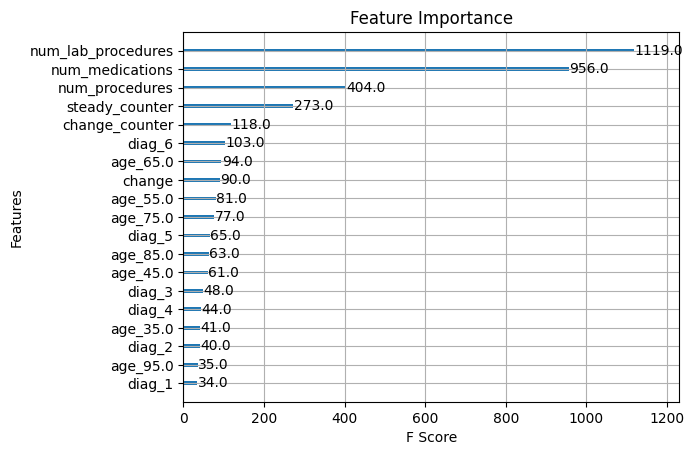

In [26]:
#XGBoost tuning
#ignore warning 
warnings.filterwarnings("ignore")

#Subset the data for faster tuning
X_subset, _, y_subset, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Define the search space for XGBoost
search_space = {
    'n_estimators': Integer(50, 300),             # Number of boosting rounds
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),  # Step size shrinkage
    'max_depth': Integer(3, 10),                 # Maximum depth of trees
    'subsample': Real(0.5, 1.0),                 # Fraction of samples used for training
    'colsample_bytree': Real(0.5, 1.0),          # Fraction of features used per tree
    'gamma': Real(0, 5),                         # Minimum loss reduction to split
    'reg_alpha': Real(0, 1),                     # L1 regularization
    'reg_lambda': Real(1, 10),                   # L2 regularization
    'scale_pos_weight': Real(1, 10),             # Balancing classes (useful for imbalanced data)
}

# Set up BayesSearchCV for XGBoost
bayes_search1 = BayesSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    search_spaces=search_space,
    n_iter=30,                 # Number of iterations
    cv=3,                      # Cross-validation folds
    n_jobs=-1,                 # Use all CPU cores
    random_state=42,
    verbose=2
)

# Fit the model
bayes_search1.fit(X_subset, y_subset)

# Print the best parameters and classification report
print("Best Parameters:", bayes_search1.best_params_)
print("Best Cross-Validation Score:", bayes_search1.best_score_)

# Evaluate the best model on the test set
y_pred = bayes_search1.best_estimator_.predict(X_test)
print("XGBoost Fine-Tuned Report:\n", classification_report(y_test, y_pred))


# Plot feature importance
plt.figure(figsize=(100, 15))
plot_importance(xgb, importance_type='weight', title="Feature Importance", xlabel="F Score")
plt.show()



XGBoost Fine-Tuned

In [27]:
# Initialize the Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data
gb.fit(X_train, y_train)

# Predict on the test data
y_pred = gb.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3163
           1       0.57      0.42      0.48      2496

    accuracy                           0.60      5659
   macro avg       0.59      0.58      0.58      5659
weighted avg       0.60      0.60      0.59      5659

Confusion Matrix:
[[2368  795]
 [1450 1046]]


In [28]:
# Gradient Boosting Classifier tuning
# Subset the data for faster tuning
X_subset, _, y_subset, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Define the search space for Gradient Boosting
search_space = {
    'n_estimators': Integer(50, 300),            # Number of boosting stages
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),  # Step size shrinkage
    'max_depth': Integer(3, 10),                # Maximum depth of the tree
    'min_samples_split': Integer(2, 10),        # Minimum samples required to split a node
    'min_samples_leaf': Integer(1, 10),         # Minimum samples required to form a leaf
    'subsample': Real(0.5, 1.0),                # Fraction of samples used for training
    'max_features': Real(0.5, 1.0),             # Fraction of features used in each tree
}

# Set up BayesSearchCV for Gradient Boosting
bayes_search = BayesSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    search_spaces=search_space,
    n_iter=30,                 # Number of iterations
    cv=3,                      # Cross-validation folds
    n_jobs=-1,                 # Use all CPU cores
    random_state=42,
    verbose=2
)

# Fit the model
bayes_search.fit(X_subset, y_subset)

# Print the best parameters and classification report
print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)

# Evaluate the best model on the test set
y_pred = bayes_search.best_estimator_.predict(X_test)
print("Gradient Boosting Fine-Tuned Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

Gradient Boosting Fine-Tuned

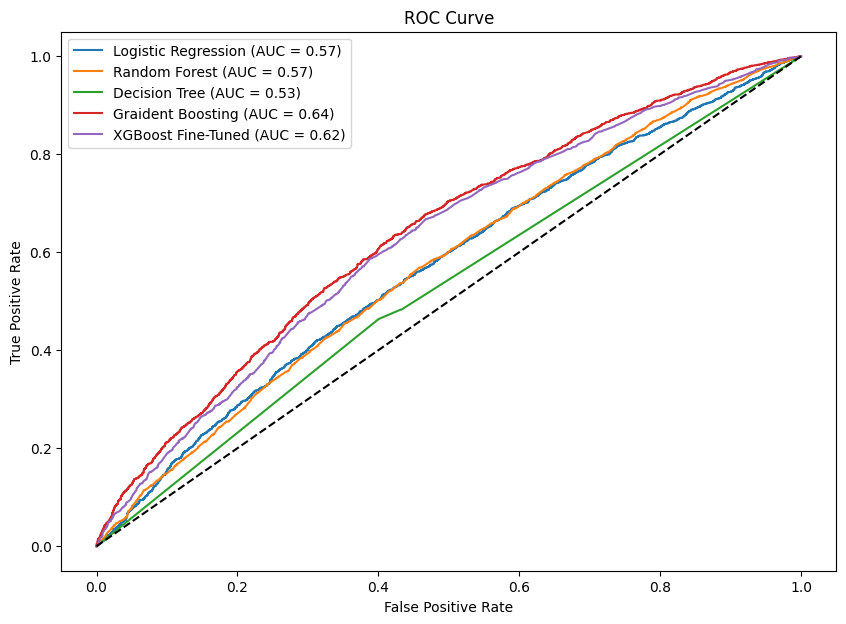

In [29]:
#ROC
#ignore warning
warnings.filterwarnings("ignore", message="This is a UserWarning that will be ignored")

# Calculate ROC-AUC for each model
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Decision Tree": dt,
    "Graident Boosting": gb,
    "XGBoost Fine-Tuned": bayes_search1
}

plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



ROC Curve and AUC